## <font color='purple'> Dimension reduction using t-SNE

<b>Name:</b> Eshita Gupta \
<b>Course:</b> Data 240 \
<b>SJSU ID:</b> 016978741 

<font color='blue'> TSNE Implementation: T-SNE (t-distributed stochastic neighbor embedding) is a non-linear dimensionality reduction technique for visualising high dimensional data in a low dimension space. They group together observations that are similar in high dimensional space and projecting them to nearby points in the low dimensional space. Nearby points in high dimensional space are mapped to nearby points in low dimensional space, and far away points in high dimensional space are mapped to far away in low dimensional space. Basically it preserves the neighborhood structure of points.

#### <font color='purple'> Building T-SNE from Scratch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<font color='blue'> Loading the data and splitting into X and y. Getting data into X as an array

In [2]:
data = pd.read_csv('fashion_mnist1.csv')

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0]

In [3]:
data.shape

(10000, 785)

<font color='blue'>Checking Null values

In [5]:
np.sum(np.isnan(X))

np.int64(0)

In [6]:
X.shape

(10000, 784)

In [7]:
y.shape

(10000,)

<font color='blue'> Using the entire Fashion MNIST dataset to perform t-SNE from scratch on it. Our input is X dataset, where each column is our feature. The ouput is representing this data into low dimensional space i.e 2D

<font color='purple'> <b>Step 1:</b> Pairwise afinities- Define the conditional Probabilities in high dimensional space i.e obtaining similarities b/w points in original space

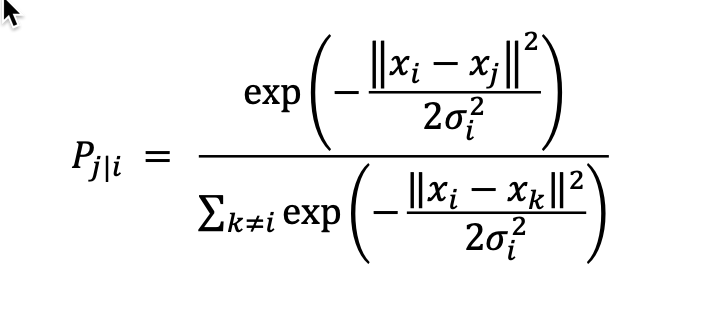 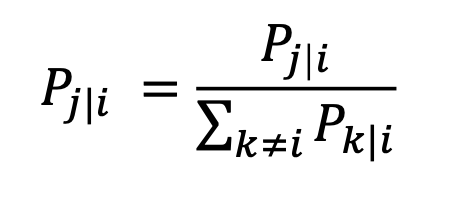 

<font color='blue'> From the above formula, we find conditional probability of each datapoint j relative to that of i. They are calculated in original space with the notion to find the probability that i would select j as its nearest neigbor in high dimensional space. We would be getting a matrix that captures the similaties b/w datapoints. These probabilities are calculated by a normal distribution centered around each point. Further, these probabilities are normalised so that the sum of the probabilities for each point  i  equals 1.
We set the diagonal elements (where  i = j ) to zero because a point is not considered its own neighbor.

<font color='blue'> These computations will result into 10000 X 10000 matrix of similarity score. The value of sigma is determined via grid search based on the perplexity parameter. We set the search space to be defined by (0.01 * standard deviation of the norms , 5 * standard deviation of the norms for the difference between images i and j) divided into 200 equal steps.

- Perplexity is defined by user that it roughly corresponds to the number of nearest neighbors for each point.
- For finding the best value of sigma, i.e to find the width of a normal distribbution, we perform a grid search. This involves testing different values of sigma to see which one makes the distribution of similarities best match the desired perplexity.
- We adjust sigma for each point until the Shannon entropy (a measure of uncertainty) of the similarities matches the desired perplexity. This ensures that the similarities reflect the local density of points around each data point.

<font color='blue'> Finding sigma

In [8]:
def perform_search(difference, i, perplexity):
    result = np.inf

    norm = np.linalg.norm(difference, axis=1)
    std_norm = np.std(norm)

    for sigma_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        p = np.exp(-(norm**2) / (2 * sigma_search**2))

        p[i] = 0

        e = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), e)

        H = -np.sum(p_new * np.log2(p_new))

        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sigma = sigma_search

    return sigma

<font color='blue'> With the above function and user defined perplexity we can calculate conditional probability in a matrix

In [9]:
def calc_similarity(X, perplexity):
    size = len(X)
    print("Calculate Conditional Probabilities....")
    p_condt = np.zeros(shape=(size, size))
    
    for iter in range(0, size):
        difference = X[iter] - X
        sigma_i = perform_search(difference, iter, perplexity)
        norm = np.linalg.norm(difference, axis=1)
        p_condt[iter, :] = np.exp(-(norm**2) / (2 * sigma_i**2))
        np.fill_diagonal(p_condt, 0)
        p_condt[iter, :] = p_condt[iter, :] / np.sum(p_condt[iter, :])

    e = np.nextafter(0, 1)
    p_condt = np.maximum(p_condt, e)

    print("Completed calculation of Conditional Probabilities. \n")
    return p_condt

<font color='blue'> Once we have the conditional probabilities, we need to convert them to joint probabilities as part of t-sne algorithm. This is obtained from the below formula. We want a matrix that captures the mutual similarity between pairs of points, considering both directions (i.e.,  i  to  j  and  j  to  i ).

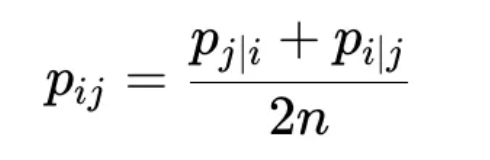

<font color='blue'>We calculate the joint probability for each pair of points by averaging the conditional probabilities in both directions and dividing by the total number of points. This results in a symmetric similarity matrix where each element represents the mutual similarity between two points.

<font color='blue'>We ensure that no element in the similarity matrix is zero by setting a minimum value close to zero to avoid numerical isssues in later steps.

In [10]:
def calc_joint_probability(p_aff):
    print("Computing Joint probabilities using the conditional probabilities")

    size = len(p_aff)
    p_joint = np.zeros(shape=(size, size))
    for i in range(0, size):
        for j in range(0, size):
            p_joint[i, j] = (p_aff[i, j] + p_aff[j, i]) / (2 * size)

    e = np.nextafter(0, 1)
    p_joint = np.maximum(p_joint, e)

    print("Completed for Joint probabilities. \n")

    return p_joint

<font color='blue'> Here, with this we will have a matrix that has symmteric joint wise probabilities as desired.

<font color='purple'> <b>Step 2:</b> Define the conditional probabilities in low-dimensional space - Calculating joint probabilities/similarities between points in Lower Dimensions

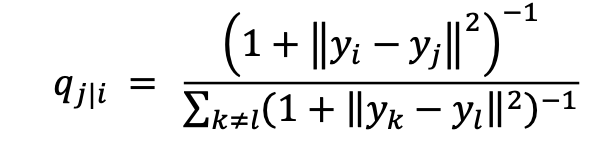

<font color='blue'> We do this by sampling a random initial solution in the lower-dimension. \
X = input array
dimensions = is the number of dimension we want for output. Here is 2 i.e 2D
Here we are using random seed values for initializing random. This function would return the initail solution for t-SNE.

In [11]:
def initialize(X, dimensions, random_seed):
    
    if random_seed is not None:
        np.random.seed(random_seed)
    
    y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), dimensions))

    return y0

<font color='blue'> Now, we shall compute the similarity or joint probability in this lower dimension space. We do this by using the above equation, and use student's t distribution here with degree of freedom =1. Here also, We set the diagonal elements (where i = j ) = 0.
Input Y is an array where each row represents a point in low dimensional space. Output will be q_joint having low dimensional similarities between data points.

First matrix q_joint is initialized as n Xn filled with zeros. Later this will store similarity b/w each pair. 

1. Calculating pairwise distances between points : diff will store difference between point i and all other points.\
norm computes the Euclidean distance (L2 norm) between point i and each other point.\
2. Applying the Student-t formula to get similarity scores: q_joint[i, :] = (1 + norm**2) ** (-1) = computed using t-distribution formula which gives higher similarity scores to closer points and lower scores to more distant points. This is the numerator part of the formula. 

3.	Setting self-similarities to zero, to ensure that similarity of point with itself is zero
4.	Normalizing the scores to sum to 1, to convert scores to probabilities.
5.	Ensuring no scores are exactly zero by replacing zero values with epsilon(e)

In [12]:
def calc_low_dim_joint_probabilities(Y):

    size = len(Y)
    q_joint = np.zeros(shape=(size, size))

    for i in range(0, size):
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_joint[i, :] = (1 + norm**2) ** (-1)

    np.fill_diagonal(q_joint, 0)

    q_joint = q_joint / q_joint.sum()

    e = np.nextafter(0, 1)
    q_joint = np.maximum(q_joint, e)

    return q_joint

  
<font color='blue'> This resulting matrix is then used in the t-SNE algorithm to adjust the positions of points in the lower-dimensional space. The goal is to make sure that the structure and relationships between the points are as similar as possible to those in the original high-dimensional data.

<font color='purple'> <b>Step 3:</b> Compute gradient of the Cost function

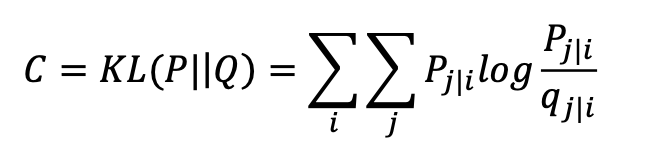 

<font color='blue'> We aim to minimize the difference between the original high-dimensional data and its lower-dimensional representation. This is done by minimizing a cost function, i.e the Kullback-Leibler (KL) divergence between the joint probability distributions in the high-dimensional space (given by  p_joint ) and the low-dimensional space (represented by  q_joint ).

Gradient of cost Function:

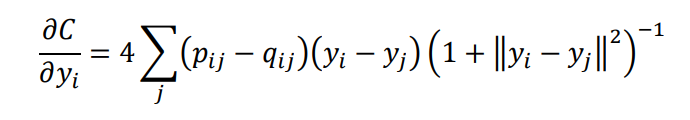 

<font color='blue'> To optimize the positions of points in the low-dimensional space, we use gradient descent. This involves computing the gradient of the cost function with respect to the positions of the points in the low-dimensional space. 
The function takes three parameters : p_joint (Joint prob dist in high dimensional space)\
, q_joint (Joint prob dist in low dimensional space) and \
Y (Current points in low-dimensional space)

<font color='blue'> 1. We start by creating an empty gradient matrix gradient with shape (size, Y.shape[1]), i.e the same length as the number of points and sameno. of dimensions as Y

<font color='blue'> 2.	Loop Through Points:
	•	Compute Differences: For each point i,  calculate difference diff between Y[i] and all other points
	•	Probability Differences: We calculate the difference between p_joint and q_joint for point i.
	•	Norm Calculation: Compute inverse norm B of the difference vectors. Adjusted by adding 1 to avoid division by zero.
	•	Gradient Calculation: We multiply the difference in probabilities (A), the inverse norm (B), and the difference vectors (C). We         then sum these results and multiply by 4

<font color='blue'> 3.	Return the Gradient: The resulting gradient matrix will have the gradient of the cost function with respect to the positions of the     points in the low-dimensional space.

In [13]:
def calc_gradient_cost_func(p_joint, q_joint, Y):

    size = len(p_joint)
    gradient = np.zeros(shape=(size, Y.shape[1]))
    
    for i in range(0, size):
        difference = Y[i] - Y
        A = np.array([(p_joint[i, :] - q_joint[i, :])])
        B = np.array([(1 + np.linalg.norm(difference, axis=1)) ** (-1)])
        C = difference
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

<font color='blue'> This gradient at current point Y is then used to update the positions of the points, iteratively minimizing the cost function and improving the low-dimensional representation of the data.

<font color='blue'> We are ready to do the optimization Problem now.

<font color='purple'> <b>Step 4:</b> Iterate & Optimize the Low-dimensional mapping

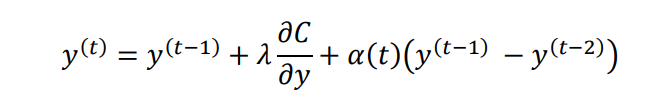 

<font color='blue'> So, to update the lower-dimensional mapping, we will use radient descent with momentum as mentioned in the original paper as shown in equaton above. Here, lambda is our learning rate and alpha(t) is our momentum term as a function of time. 

<font color='blue'>The learning rate controls the step size at each iteration 
The momentum term allows the optimization algorithm to gain inertia to move into the smooth direction of the search space.
We can experiment with different learning rates and momentum for the update rule, to run the optimization over a set of no. of iterations. 

<font color='blue'>We also see the term “early exaggeration” as mentioned in original paper. It emphasizes clusters of similar points in early iterations.
By doing this, we give more importance to very similar points in the initial stages. which would help to form clear clusters of similar points in the low-dimensional space.

#### <font color='purple'> TSNE algorithm: putting it altogether.


<font color='blue'> 1.	Parameters:
	X: Input data matrix, perplexity, max_iter, learning_rate, momentum, early_exaggeration, random_seed as discussed above. </br></br>
<font color='blue'>2.	Initialization:
	Compute conditional probabilities (p_cond).
	Compute joint probabilities (p_joint).
	Initialize low-dimensional representation Y with zeros and set initial values.</br></br>
<font color='blue'>3.	Iteration Loop:
	For each iteration (up to max_iter):
	Compute low-dimensional joint probabilities (q_joint).
	Calculate gradient of cost function.
	Update Y using gradient descent with momentum.
	Print cost function value at specific intervals.</br></br>
<font color='blue'>4.	Completion:
	Print final cost function value.
	Return the final low-dimensional embeddings (result) and history of embeddings (Y).</br></br>

In [14]:
def tsne(X,perplexity,max_iter,learning_rate,momentum,early_exaggeration,random_seed):

    size = len(X)
    dimension_count = 2

    p_cond = calc_similarity(X, perplexity)
    p_joint = calc_joint_probability(p_cond)

    Y = np.zeros(shape=(max_iter, size, dimension_count))
    Y_minus1 = np.zeros(shape=(size, dimension_count))
    Y[0] = Y_minus1
    Y1 = initialize(X, dimension_count, random_seed)
    Y[1] = np.array(Y1)

    for t in range(1, max_iter - 1):

        q_joint = calc_low_dim_joint_probabilities(Y[t])

        gradient = calc_gradient_cost_func(early_exaggeration * p_joint, q_joint, Y[t])

        Y[t + 1] = Y[t] - learning_rate * gradient + momentum * (Y[t] - Y[t - 1])

        if t % 50 == 0 or t == 1 or t == max_iter or t == max_iter-1:
            cost = np.sum(p_joint * np.log(p_joint / q_joint))
            print(f"Iteration Number {t}/{max_iter}: Cost Function Value = {cost}")

    print(f"Completed all iterations. Cost Function = {np.sum(p_joint * np.log(p_joint / q_joint))}")
    
    result = Y[-1]

    return result, Y

<font color='blue'> Using the t-SNE method, please reduce the 784 dimensions to 2 dimensions.
Please try at least 5 different hyperparameters conditions.
For each hyperparameter condition, please calculate its corresponding D and J
Please calculate the sum of the distance D among the 10 centroids. Each centroid corresponds to each label.
Since there are 10 centroids, you should calculate distance for 45 pairs.

<font color='blue'> For the task of calculating distances between centroids, the logic of 45 pairs comes from the combination of 10 centroids:

<font color='blue'> When we reduce the 784 dimensions to 2 dimensions, we do this while preserving the relative distances between points. For that, we calculate distance between 10 centroids, and there would be 45 combinations, unique pairs among 10 centroids. The formula for calculation of centroids and distances is calculated by the formula below. 

<font color='blue'> Centroid and D calculation
	1.	Calculating  D  (Sum of Pairwise Distances Between Centroids): calculating the sum of squared distances between each pair (45 unique pair)of centroids.

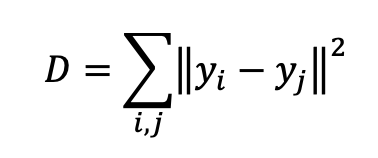 

In [15]:
def calculate_D(centroids):
    D = 0
    num_centroids = len(centroids)
    for i in range(num_centroids):
        for j in range(i + 1, num_centroids):
            D += np.sum((centroids[i] - centroids[j])**2)
    return D

In [16]:
def compute_centroids(Y, labels):
    centroids = []
    for label in np.unique(labels):
        points = Y[labels == label]
        centroid = np.mean(points, axis=0)
        centroids.append(centroid)
    return np.array(centroids)

<font color='blue'> Calculating the sum of squared distances between each point and the centroid of its corresponding label using the below formula

<font color='blue'> J Calculation

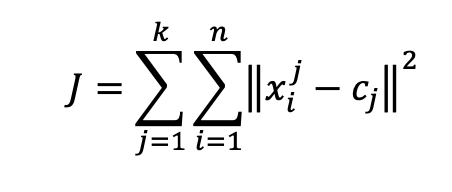 

In [17]:
def calculate_J(X, centroids, labels):
    J = 0
    for i in range(len(X)):
        centroid = centroids[labels[i]]
        J += np.sum((X[i] - centroid)**2)
    return J

<font color='blue'> tsne_with_calculations:<br>
	Runs the t-SNE algorithm.\
	Computes centroids based on the reduced dimensions.\
	Calculates the sum of distances  D  among centroids.\
	Calculates the objective function  J .

In [18]:
def tsne_with_calculations(X, y, perplexity, max_iter, learning_rate, momentum, early_exaggeration, random_seed):
    result, Y = tsne(X, perplexity, max_iter, learning_rate, momentum, early_exaggeration, random_seed)
    centroids = compute_centroids(result, y)
    D = calculate_D(centroids)
    J = calculate_J(result, centroids, y)
    return result, Y, D, J

In [19]:
def run_tsne_experiments(X, y, iterations, params):
    results = []

    for i in range(iterations):
        print(f'Starting Experiment - {i+1}')
        print("-" * 60)
        perplexity = params[i]['perplexity']
        max_iter = params[i]['max_iter']
        learning_rate = params[i]['learning_rate']
        momentum = params[i]['momentum']
        early_exaggeration = params[i]['early_exaggeration']
        random_seed = params[i]['random_seed']
        print(f'perplexity - {perplexity}')
        print(f'max_iter - {max_iter}')
        print(f'learning_rate - {learning_rate}') 
        print(f'momentum - {momentum}') 
        print(f'early_exaggeration - {early_exaggeration}') 
        print(f'random_seed - {random_seed}')
        print("-" * 60)
        result, Y, D, J = tsne_with_calculations(
            X, y, perplexity, max_iter, learning_rate, momentum, early_exaggeration, random_seed
        )
        
        results.append({
            'result': result,
            'Y': Y,
            'D': D,
            'J': J,
            'params': params[i]
        })
        print("-" * 60)

    return results

<font color='blue'> Experimenting with different hyperparameters to run the optimization problem to maximize the distance D among the centroids and to minimize the objective function J

In [18]:
params = [
    {'perplexity': 5, 'max_iter': 100, 'learning_rate': 200, 'momentum': 0.7, 'early_exaggeration': 16, 'random_seed': 73},
    {'perplexity': 10, 'max_iter': 200, 'learning_rate': 150, 'momentum': 0.75, 'early_exaggeration': 14, 'random_seed': 211},
    {'perplexity': 20, 'max_iter': 300, 'learning_rate': 100, 'momentum': 0.8, 'early_exaggeration': 12, 'random_seed': 37},
    {'perplexity': 30, 'max_iter': 400, 'learning_rate': 50, 'momentum': 0.85, 'early_exaggeration': 10, 'random_seed': 79},
    {'perplexity': 40, 'max_iter': 500, 'learning_rate': 10, 'momentum': 0.9, 'early_exaggeration': 8, 'random_seed': 59}
]

results = run_tsne_experiments(X, y, iterations=len(params), params=params)

Starting Experiment - 1
------------------------------------------------------------
perplexity - 5
max_iter - 100
learning_rate - 200
momentum - 0.7
early_exaggeration - 16
random_seed - 73
------------------------------------------------------------
Calculate Conditional Probabilities....


/var/folders/f9/tzl1jwjn3f3fvhyb_dm77j6h0000gn/T/ipykernel_2373/3070624741.py:13: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), e)


Completed calculation of Conditional Probabilities. 

Computing Joint probabilities using the conditional probabilities
Completed for Joint probabilities. 

Iteration Number 1/100: Cost Function Value = 7.241975860610611
Iteration Number 50/100: Cost Function Value = 7.264434155941023
Completed all iterations. Cost Function = 5.922751258395411
------------------------------------------------------------
Starting Experiment - 2
------------------------------------------------------------
perplexity - 10
max_iter - 200
learning_rate - 150
momentum - 0.75
early_exaggeration - 14
random_seed - 211
------------------------------------------------------------
Calculate Conditional Probabilities....
Completed calculation of Conditional Probabilities. 

Computing Joint probabilities using the conditional probabilities
Completed for Joint probabilities. 

Iteration Number 1/200: Cost Function Value = 6.587569654750657
Iteration Number 50/200: Cost Function Value = 6.588988109729949
Iteration Nu

<font color='blue'> Plotting the results based on the 5 Different Hyperparameter combinations

Printing Results and Plotting
Experiment 1:
Distance D among the centroids: 319.8819401444549
Objective function J: 7178.323974423862
Parameters: {'perplexity': 5, 'max_iter': 100, 'learning_rate': 200, 'momentum': 0.7, 'early_exaggeration': 16, 'random_seed': 73}


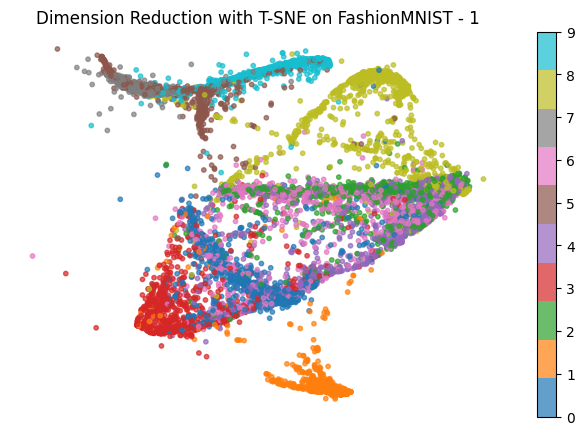

Experiment 2:
Distance D among the centroids: 817.168261656906
Objective function J: 28965.441302382907
Parameters: {'perplexity': 10, 'max_iter': 200, 'learning_rate': 150, 'momentum': 0.75, 'early_exaggeration': 14, 'random_seed': 211}


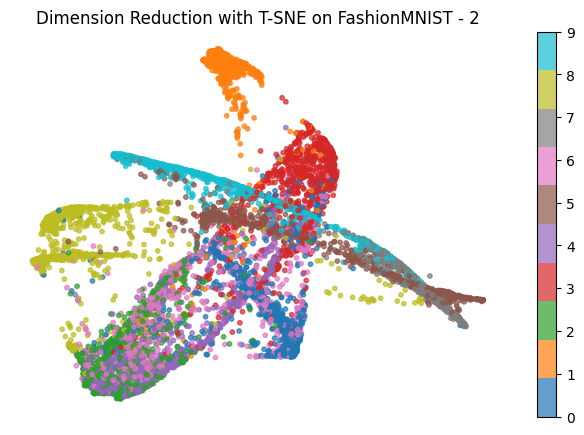

Experiment 3:
Distance D among the centroids: 1242.6362135221407
Objective function J: 21913.213671141646
Parameters: {'perplexity': 20, 'max_iter': 300, 'learning_rate': 100, 'momentum': 0.8, 'early_exaggeration': 12, 'random_seed': 37}


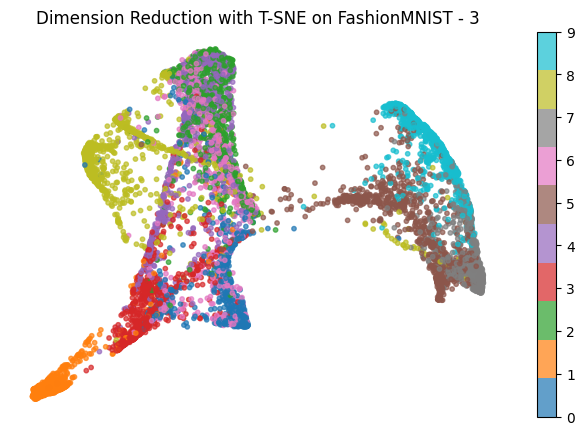

Experiment 4:
Distance D among the centroids: 1188.303301429838
Objective function J: 23807.724573337335
Parameters: {'perplexity': 30, 'max_iter': 400, 'learning_rate': 50, 'momentum': 0.85, 'early_exaggeration': 10, 'random_seed': 79}


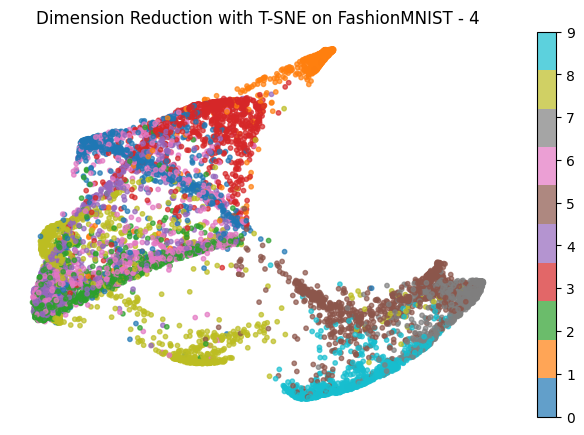

Experiment 5:
Distance D among the centroids: 160.52091153955885
Objective function J: 2929.9345178520216
Parameters: {'perplexity': 40, 'max_iter': 500, 'learning_rate': 10, 'momentum': 0.9, 'early_exaggeration': 8, 'random_seed': 59}


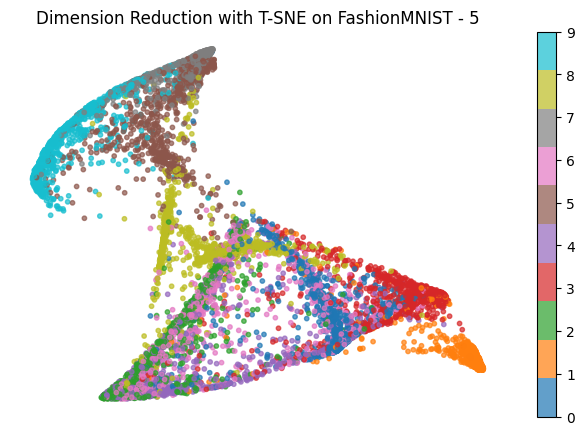

In [19]:
print("=" * 40)
print("Printing Results and Plotting")
print("=" * 40)

for idx, result in enumerate(results):
    print(f"Experiment {idx + 1}:")
    print(f"Distance D among the centroids: {result['D']}")
    print(f"Objective function J: {result['J']}")
    print(f"Parameters: {result['params']}")
    print("=" * 40)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    g1 = ax.scatter(result['result'][:, 0], result['result'][:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
    ax.axis("off")
    ax.set_title(f"Dimension Reduction with T-SNE on FashionMNIST - {idx + 1}")
    plt.colorbar(g1, ax=ax)
    plt.show()

<font color='blue'> We ran 5 experiments with different hyper parameters and found that the value of D was better with perplexity as 30 and high number of iterations. We next tried with different combinations of Perplexity 30 and found that lower early exaggeration and low learning rate with a medium momentum and 0 as random seed yielded the highest value of D. 

<font color='blue'> Following are the results with one such combination

In [20]:
params = [
    # {'perplexity': 30, 'max_iter': 1500, 'learning_rate': 200, 'momentum': 0.7, 'early_exaggeration': 16, 'random_seed': 0}]
    # {'perplexity': 30, 'max_iter': 200, 'learning_rate': 250, 'momentum': 0.7, 'early_exaggeration': 2, 'random_seed': 111}]
    {'perplexity': 30, 'max_iter': 1000, 'learning_rate': 110, 'momentum': 0.6, 'early_exaggeration': 3, 'random_seed': 0}]
results2 = run_tsne_experiments(X, y, iterations=len(params), params=params)

Starting Experiment - 1
------------------------------------------------------------
perplexity - 30
max_iter - 1000
learning_rate - 110
momentum - 0.6
early_exaggeration - 3
random_seed - 0
------------------------------------------------------------
Calculate Conditional Probabilities....


/var/folders/f9/tzl1jwjn3f3fvhyb_dm77j6h0000gn/T/ipykernel_36204/3070624741.py:13: RuntimeWarning: invalid value encountered in divide
  p_new = np.maximum(p / np.sum(p), e)


Completed calculation of Conditional Probabilities. 

Computing Joint probabilities using the conditional probabilities
Completed for Joint probabilities. 

Iteration Number 1/1000: Cost Function Value = 5.536272934100613
Iteration Number 50/1000: Cost Function Value = 5.53627161302824
Iteration Number 100/1000: Cost Function Value = 5.530793300838118
Iteration Number 150/1000: Cost Function Value = 4.908382882837242
Iteration Number 200/1000: Cost Function Value = 4.140481080967235
Iteration Number 250/1000: Cost Function Value = 3.7153921969634482
Iteration Number 300/1000: Cost Function Value = 3.4508260025977178
Iteration Number 350/1000: Cost Function Value = 3.264487600398978
Iteration Number 400/1000: Cost Function Value = 3.125557314188604
Iteration Number 450/1000: Cost Function Value = 3.017909227088414
Iteration Number 500/1000: Cost Function Value = 2.931660830643633
Iteration Number 550/1000: Cost Function Value = 2.8607673579692725
Iteration Number 600/1000: Cost Function

<font color='blue'> Plotting the results with the best combination as per our experiments

Printing Results and Plotting
Experiment 1:
Distance D among the centroids: 8875.525625549279
Objective function J: 320997.68728358427
Parameters: {'perplexity': 30, 'max_iter': 1000, 'learning_rate': 110, 'momentum': 0.6, 'early_exaggeration': 3, 'random_seed': 0}


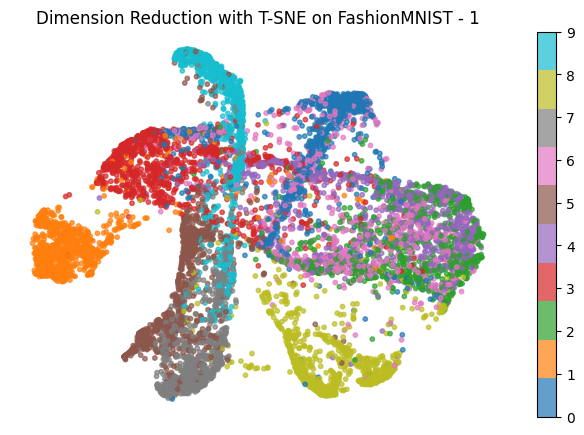

In [21]:
print("=" * 40)
print("Printing Results and Plotting")
print("=" * 40)

for idx, result in enumerate(results2):
    print(f"Experiment {idx + 1}:")
    print(f"Distance D among the centroids: {result['D']}")
    print(f"Objective function J: {result['J']}")
    print(f"Parameters: {result['params']}")
    print("=" * 40)
    
    fig, ax = plt.subplots(figsize=(8, 5))
    g1 = ax.scatter(result['result'][:, 0], result['result'][:, 1], c=y, cmap="tab10", s=10, alpha=0.7)
    ax.axis("off")
    ax.set_title(f"Dimension Reduction with T-SNE on FashionMNIST - {idx + 1}")
    plt.colorbar(g1, ax=ax)
    plt.show()

<font color='blue'> We are able to visually assess the clustering results. Different colors represent different labels (clusters). Ideally, we want to see clear and distinct clusters with minimal overlap.

<font color='blue'> The value of 8875.5256 indicates the total sum of distances between all pairs of centroids. A higher  D  value generally suggests better separation between the clusters, meaning that the clusters are more distinct and well-separated in the 2D space.


<font color='blue'> To validate my results, I compared my execution parameters by running the same with the standard Scikit-Learn Library. Following is a quick plot on the same for comparison.

/opt/miniconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


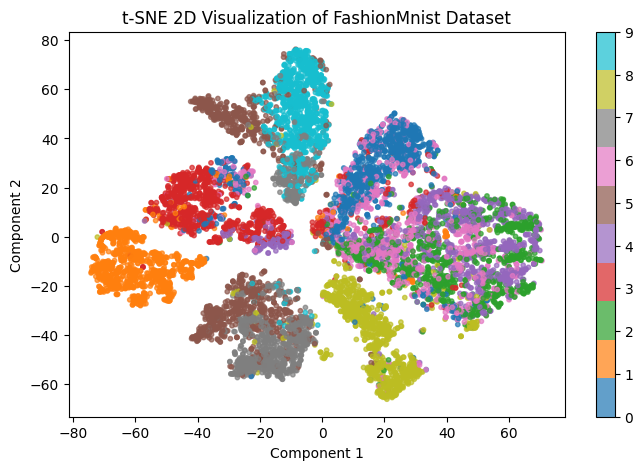

In [25]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Initialize t-SNE
tsne_1 = TSNE(n_components=2, 
              perplexity=30, 
              n_iter=1000, 
              random_state=0, 
              early_exaggeration=3, 
              init='random', 
              learning_rate=110.0)

# Fit and transform the data
X_embedded = tsne_1.fit_transform(X)

# Plot the result
plt.figure(figsize=(8, 5))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.colorbar()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE 2D Visualization of FashionMnist Dataset')
plt.show()

<font color='blue'> I see my results with custom T-SNE implementation are almost comparable to the standard implementation in the Scikit-Learn library. However, with further experimentation and tuning of hyperparameters, even better results might be achieved. Due to computational complexity, leaving it here with 1000 iterations on my custom TSNE model.

## Thank You